In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [2]:
RESULTS_FOLDER = "../untracked/outputs/evaluated"

# Remove effect of incopmplete tags (just for testing the classifiers)
REMOVE_MISSING_LABELS = False  # Set this to true to remove all entities not asssociated to a manually tagged instance
REMOVE_MISSING_SAM = False

In [3]:
rows = list()

for model in os.listdir(RESULTS_FOLDER):
    
    model_preds = list()
    coco_labels = list()
    for test in os.listdir(os.path.join(RESULTS_FOLDER,model)):
        if '.csv' in test:
            this_test = pd.read_csv(os.path.join(RESULTS_FOLDER,model, test))

            if REMOVE_MISSING_SAM:
                this_test = this_test.loc[this_test['cell_id_sam']>=0]
            if REMOVE_MISSING_LABELS:
                this_test = this_test.loc[this_test['cell_id_coco']>=0]

            
            model_preds += this_test['is_cell_sam'].values.tolist()
            coco_labels +=  this_test['is_cell_ground_truth'].values.tolist()


    model_preds = np.array(model_preds).astype(int)
    coco_labels = np.array(coco_labels).astype(int)
    if "AutoEncoder" in model:
        model_preds = 1-model_preds
    print(f"{model} -- True Rate: {model_preds.sum()/(len(model_preds)):0.2f}")        

    rows.append([model, 
                 accuracy_score(coco_labels, model_preds), 
                 precision_score(coco_labels, model_preds), 
                 recall_score(coco_labels, model_preds), 
                 confusion_matrix(coco_labels, model_preds) # tn, fp, fn, tp
                 ])

results = pd.DataFrame(rows, columns=['model', 
                                      'accuracy_score', 
                                      'precision_score', 
                                      'recall_score', 
                                      'confusion_matrix'])
results = results.sort_values('recall_score', ascending=False).reset_index(drop=True)


DenseNet121_model_FR -- True Rate: 0.23
InceptionV3_model_FR -- True Rate: 0.24
SupervisedTrain-EncoderType_AutoEncoder_v2-DatasetType_VGG16_kmeans_v0 -- True Rate: 0.62
ResNet50_model_FR -- True Rate: 0.35
MobileNetV2_model_FR -- True Rate: 0.32
VGG19_model_FR -- True Rate: 0.26
VGG16_model_FR -- True Rate: 0.24


In [4]:
results

,model,accuracy_score,precision_score,recall_score,confusion_matrix
0,SupervisedTrain-EncoderType_AutoEncoder_v2-Dat...,0.526039,0.520241,0.646499,"[[1199, 1754], [1040, 1902]]"
1,ResNet50_model_FR,0.469890,0.455169,0.315772,"[[1841, 1112], [2013, 929]]"
2,MobileNetV2_model_FR,0.490416,0.483333,0.305574,"[[1992, 961], [2043, 899]]"
3,VGG19_model_FR,0.504665,0.507106,0.266825,"[[2190, 763], [2157, 785]]"
4,VGG16_model_FR,0.512638,0.524279,0.253229,"[[2277, 676], [2197, 745]]"
5,InceptionV3_model_FR,0.508567,0.516083,0.245411,"[[2276, 677], [2220, 722]]"
6,DenseNet121_model_FR,0.503647,0.505944,0.231475,"[[2288, 665], [2261, 681]]"


# Plots

In [5]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    # From documentation of scypy and wikipedia
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    # https://en.wikipedia.org/wiki/Confusion_matrix
    # We need to re-rder the matrix
    tn, fp, fn, tp = cm.ravel()

    cm = np.array([[tp, fn],[fp, tn]])

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.nan_to_num(cm, 0)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

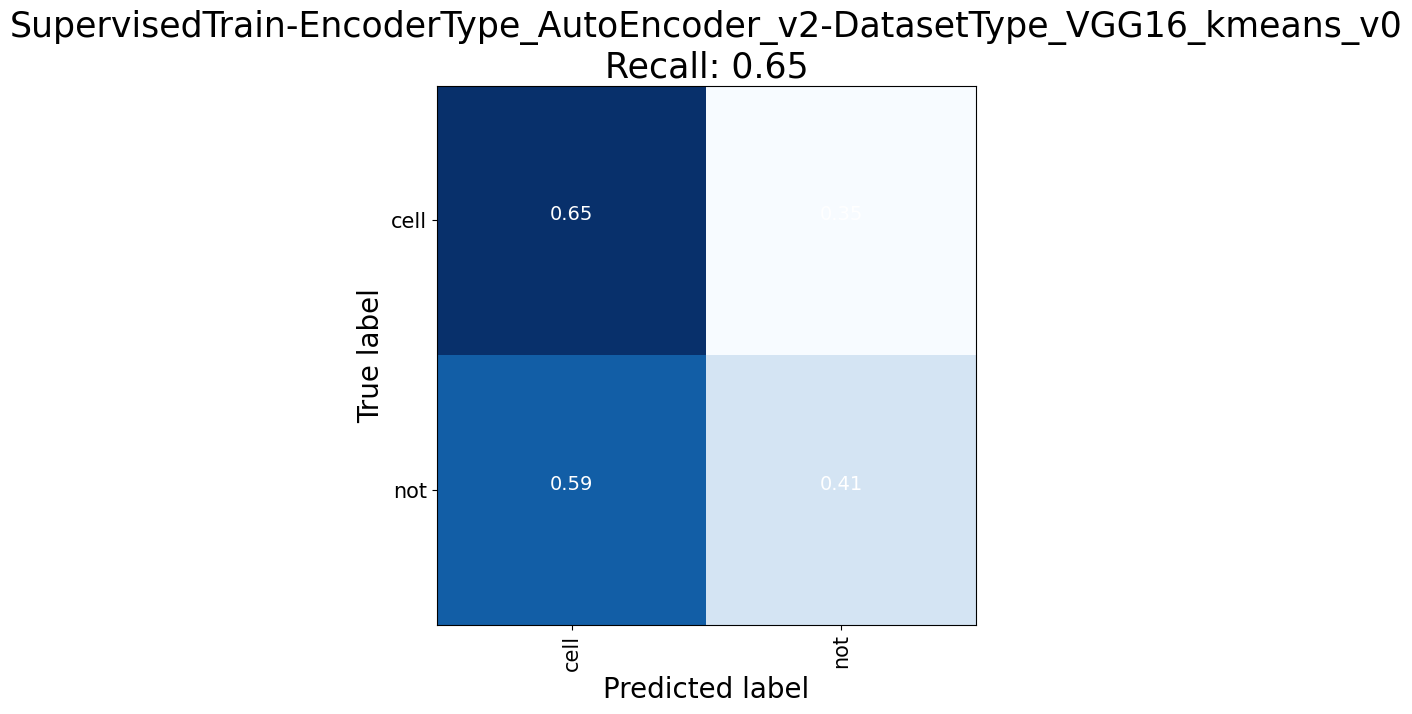

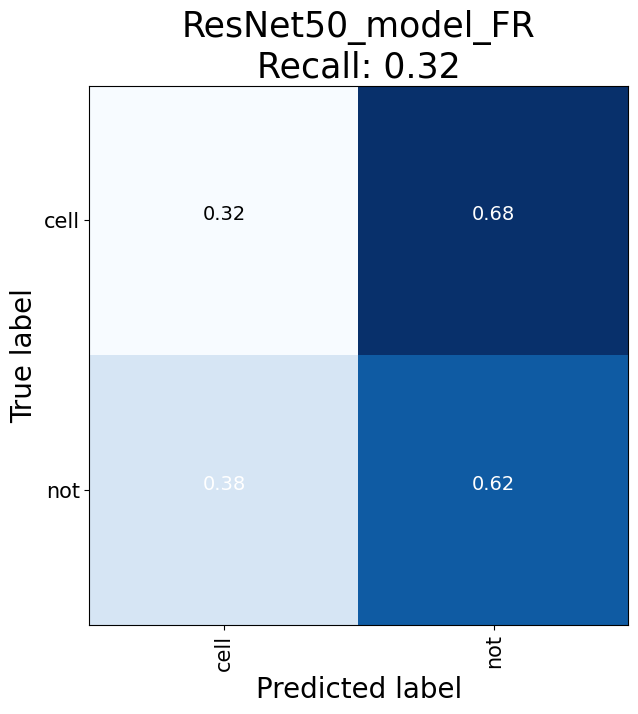

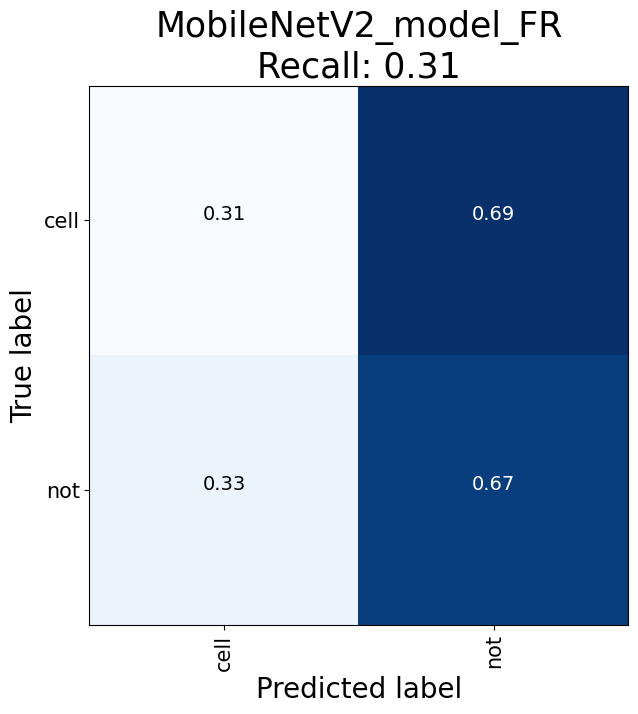

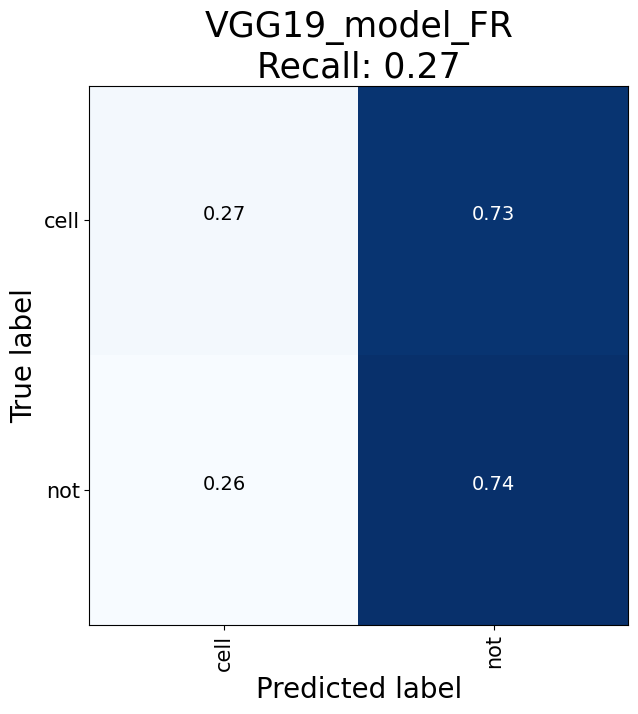

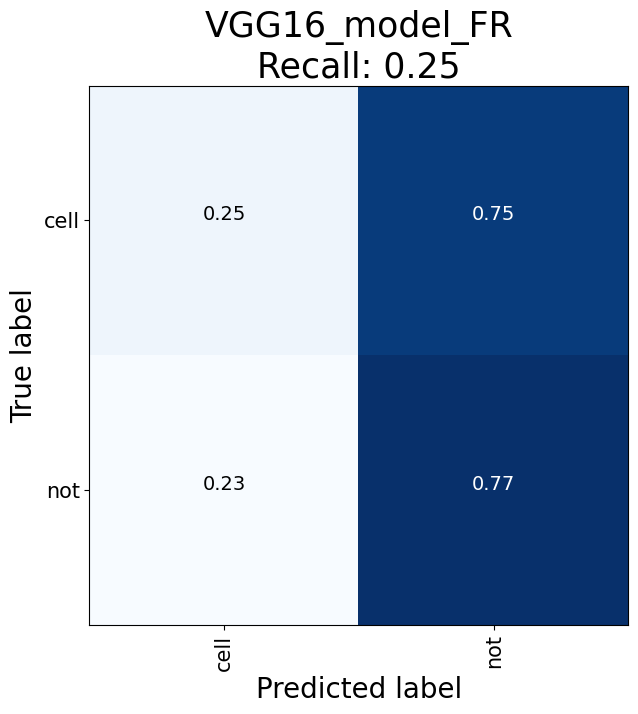

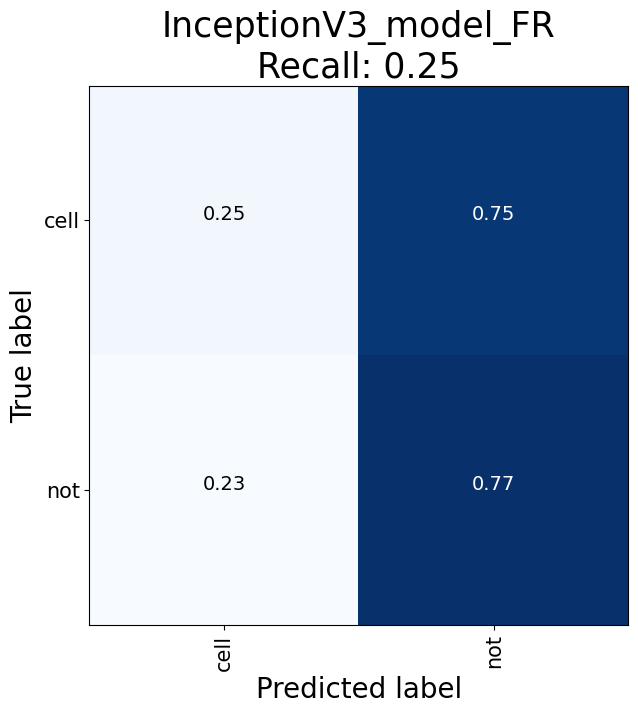

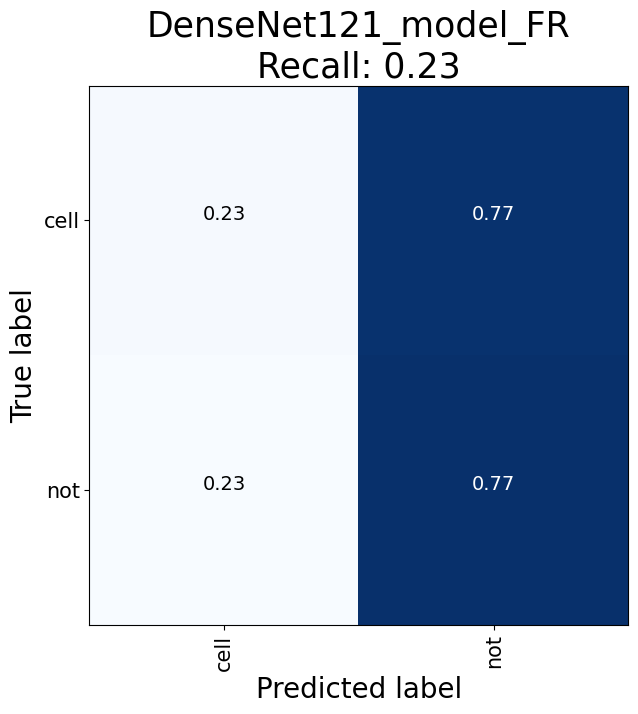

In [6]:
for idx, row in results.iterrows():
    plt.figure(figsize=(7,7))
    plot_confusion_matrix(row.confusion_matrix, classes=['cell', 'not'], title=f"{row.model}\nRecall: {row.recall_score:0.2f}")
    plt.show()